In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
fn_src = 'https://www.dropbox.com/sh/n4924ipcfjqc0t6/AADOv9JYMUBK1tlg9P71gSSra/example_data_s1.pickle?dl=1'
fn_dst = 'example_data_s1.pickle'

import os
from six.moves import urllib

if os.path.isfile(fn_dst):
    print('File %s is already downloaded' % fn_dst)
else:        
    urllib.request.urlretrieve(fn_src, fn_dst)

File example_data_s1.pickle is already downloaded


In [3]:
with open('example_data_s1.pickle', 'rb') as fp:
    X,y = pickle.load(fp)

In [4]:
tsamp = 0.05
nt, nneuron = X.shape
nout = y.shape[1]
ttotal = nt*tsamp
print('Number of neurons = %d' % nneuron)
print('Number of time samples = %d' % nt)
print('Number of outputs = %d' % nout)
print('Total time (secs) = %f' % ttotal)

Number of neurons = 52
Number of time samples = 61339
Number of outputs = 2
Total time (secs) = 3066.950000


In [5]:
from sklearn.model_selection import train_test_split
Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=0.33)

In [6]:
regr = LinearRegression()
regr.fit(Xtr,ytr)
yhat = regr.predict(Xts)
rsq = r2_score(yts, yhat)
print(rsq)

0.46488757273604486


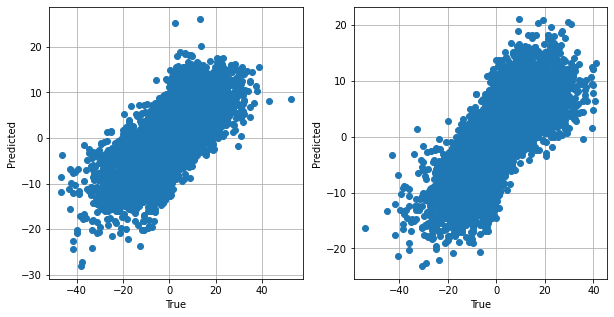

In [7]:
plt.figure(figsize=(10,5))
for i in range(nout):
  plt.subplot(1,nout,i+1)
  plt.plot(yts[:,i],yhat[:,i],'o')
  plt.grid()
  plt.xlabel('True')
  plt.ylabel('Predicted')

In [9]:
def create_dly_data(X,y,dly):
  n,p = X.shape
  Xdly = np.zeros((n-dly,(dly+1)*p))
  for i in range(dly+1):
    Xdly[:,i*p:(i+1)*p] = X[dly-i:n-i,:]
    ydly = y[dly:]
  return Xdly, ydly

In [10]:
dly = 6
Xdly, ydly = create_dly_data(X,y,dly)
Xtr, Xts, ytr, yts = train_test_split(Xdly, ydly, test_size=0.33)
regr = LinearRegression()
regr.fit(Xtr,ytr)
yhat = regr.predict(Xts)
rsq = r2_score(yts, yhat)
print(rsq)

0.6895429234099439


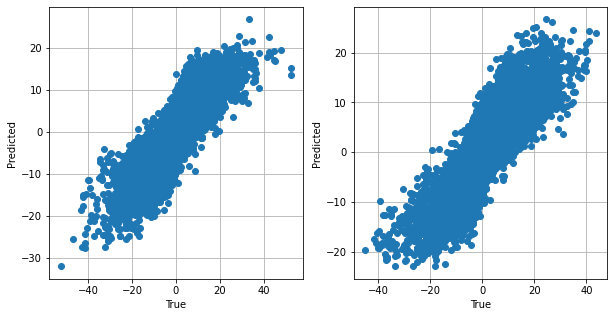

In [11]:
plt.figure(figsize=(10,5))
for i in range(nout):
  plt.subplot(1,nout,i+1)
  plt.plot(yts[:,i],yhat[:,i],'o')
  plt.grid()
  plt.xlabel('True')
  plt.ylabel('Predicted')

In [12]:
nred = 6000
Xred = X[:nred]
yred = y[:nred]

In [13]:
dmax = 15
Xdly, ydly = create_dly_data(Xred,yred,dmax)

In [15]:
import sklearn.model_selection
from tqdm import tqdm_notebook

nfold = 5

kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)

dtest = np.arange(dmax+1)
nd = len(dtest)

Rsq = np.zeros((nd,nfold))
Rss = np.zeros((nd,nfold))

pbar = tqdm_notebook(
total=nfold*nd, initial=0,
unit='folds', unit_divisor=nd, desc='Model order test')

for isplit, Ind in enumerate(kf.split(Xdly)):
  Itr, Its = Ind
  for it, d in enumerate(dtest):
    Xdly1 = Xdly[:,:(d+1)*nneuron]
    Xtr = Xdly1[Itr,:]
    ytr = ydly[Itr]
    Xts = Xdly1[Its,:]
    yts = ydly[Its]
    
    regr.fit(Xtr,ytr)
    yhat = regr.predict(Xts)

    Rsq[it,isplit] = r2_score(yts, yhat)
    Rss[it,isplit] = np.mean((yts-yhat)**2)

    pbar.update(1)
pbar.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


Model order test:   0%|          | 0/80 [00:00<?, ?folds/s]

Text(0, 0.5, 'Test RSS')

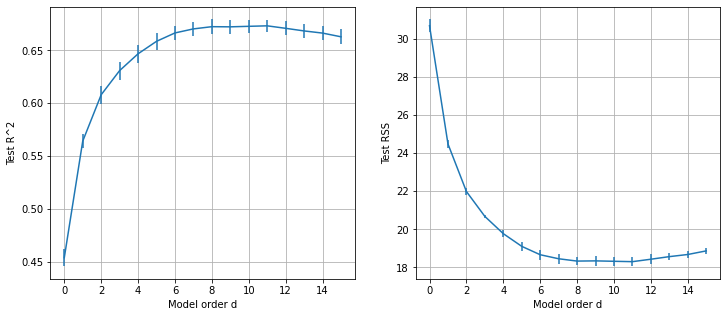

In [16]:
rsq_mean = np.mean(Rsq,axis=1)
rsq_se = np.std(Rsq,axis=1)/np.sqrt(nfold-1)
rss_mean = np.mean(Rss,axis=1)
rss_se = np.std(Rss,axis=1)/np.sqrt(nfold-1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.errorbar(dtest, rsq_mean, rsq_se)
plt.grid()
plt.xlabel('Model order d')
plt.ylabel('Test R^2')

plt.subplot(1,2,2)
plt.errorbar(dtest, rss_mean, rss_se)
plt.grid()
plt.xlabel('Model order d')
plt.ylabel('Test RSS')

In [17]:
iopt = np.argmax(rsq_mean)
dopt = dtest[iopt]
print('Optimal model order with normal rule = %d' % dopt)
print('R^2 = %f' % rsq_mean[iopt])

Optimal model order with normal rule = 11
R^2 = 0.673284


In [18]:
rsq_tgt = rsq_mean[iopt] - rsq_se[iopt]
I = np.where(rsq_mean >= rsq_tgt)[0]
iopt_one_se = I[0]
dopt_one_se = dtest[iopt_one_se]
print('Optimal model order with one SE rule = %d' % dopt_one_se)
print('R^2 = %f' % rsq_mean[iopt_one_se])

Optimal model order with one SE rule = 7
R^2 = 0.670383
